# Handwriting digit recognition using neural networks

## Neural Network
Neural network adalah model yang terinspirasi oleh bagaimana neuron dalam otak manusia bekerja. Tiap neuron pada otak manusia saling berhubungan dan informasi mengalir dari setiap neuron tersebut. Gambar di bawah adalah ilustrasi neuron dengan model matematisnya.

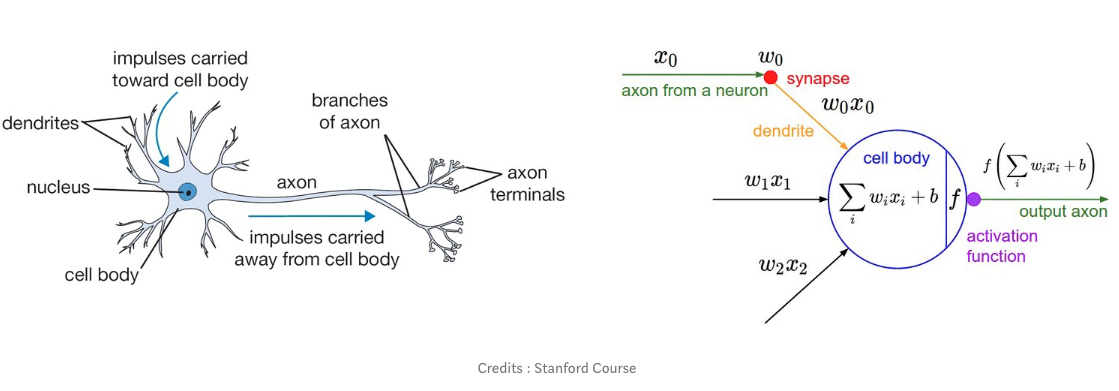

Tiap neuron menerima input dan melakukan operasi perkalian vector input dengan sebuah weight, menjumlahkannya (weighted sum) dan menambahkan bias. Hasil dari operasi ini akan dijadikan parameter dari activation function yang akan dijadikan output dari neuron tersebut.

## Neural Network Architecture
Pada neural network ini memiliki 784 input dan juga 2 hidden layer, layer pertama memiliki 256 neuron sedangkan layer kedua memiliki 128 neuron, terakhir kita memiliki output layer berjumlah 10 yang merupakan label angka 1-9


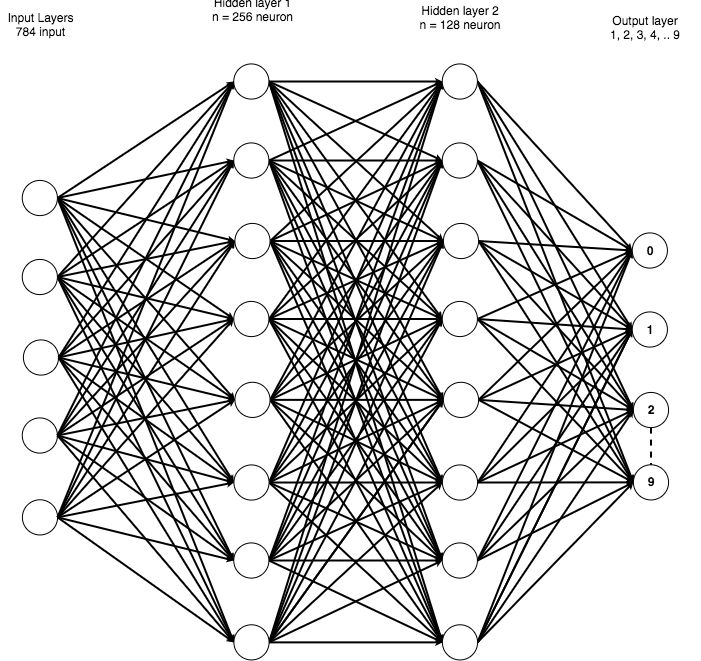

### Import package

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np

import matplotlib.pyplot as plt

from keras.datasets import mnist

Using TensorFlow backend.




Now we will build neural network to clasify text in the images. We will use MNIST dataset, the MNIST database (Modified National Institute of Standards and Technology database) of handwritten digits consists of a training set of 60,000 examples, and a test set of 10,000 examples. Additionally, the black and white images from NIST were size-normalized and centered to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

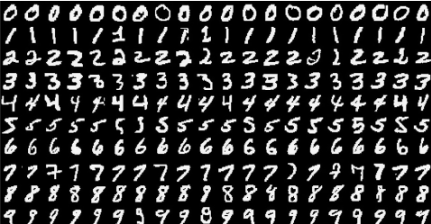



## Acquire data

Some library like keras provide this dataset. or you can download it here https://www.python-course.eu/data/mnist/mnist_train.csv and https://www.python-course.eu/data/mnist/mnist_test.csv

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("images shape : ",x_train.shape)
print("labels shape : ", y_train.shape)

images shape :  (60000, 28, 28)
labels shape :  (60000,)


### Flatten & Normalization
The networks you'll build are called _fully-connected or dense_ networks. Each unit in one layer is connected to each unit in the next layer. In fully connected networks, the input to each layer must be a one-dimensional vector. However, out images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about size we need to convert our images with shape `(60000, 28, 28)` to have a shape of `(60000, 784)`.

The images of the MNIST dataset are greyscale and the pixels range between 0 and 255 including both bounding values. We will map these values into an interval from [0.01, 1] by multiplying each pixel by 0.99 / 255 and adding 0.01 to the result. This way, we avoid 0 values as inputs, which are capable of preventing weight updates.

In [3]:

# flattening
x_train = x_train.reshape(60000, 28*28).astype('float32')
x_test = x_test.reshape(10000, 28*28).astype('float32')


# normalization
fac = 0.99 / 255
train_imgs = np.asfarray(x_train) * fac + 0.01
test_imgs = np.asfarray(x_test) * fac + 0.01
train_labels = np.asfarray(y_train)
test_labels = np.asfarray(y_test)


### One Hot Encoding
one hot encoding is a process by which categorical variables are converted to form that could be provided to algorithm to do a better job in prediction.

We are ready now to turn our labelled images into one-hot representations. Instead of zeroes and one, we create 0.01 and 0.99, which will be better for our calculations

In [4]:
# one hot encoding samples
lr = np.arange(10)

for label in range(10):
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one-hot representation: ", one_hot)

label:  0  in one-hot representation:  [1 0 0 0 0 0 0 0 0 0]
label:  1  in one-hot representation:  [0 1 0 0 0 0 0 0 0 0]
label:  2  in one-hot representation:  [0 0 1 0 0 0 0 0 0 0]
label:  3  in one-hot representation:  [0 0 0 1 0 0 0 0 0 0]
label:  4  in one-hot representation:  [0 0 0 0 1 0 0 0 0 0]
label:  5  in one-hot representation:  [0 0 0 0 0 1 0 0 0 0]
label:  6  in one-hot representation:  [0 0 0 0 0 0 1 0 0 0]
label:  7  in one-hot representation:  [0 0 0 0 0 0 0 1 0 0]
label:  8  in one-hot representation:  [0 0 0 0 0 0 0 0 1 0]
label:  9  in one-hot representation:  [0 0 0 0 0 0 0 0 0 1]


In [5]:
# one hot encoding our labels
train_targets = np.array(train_labels).astype(np.int)
train_labels_one_hot = np.eye(np.max(train_targets) + 1)[train_targets]

test_targets = np.array(test_labels).astype(np.int)
test_labels_one_hot = np.eye(np.max(test_targets) + 1)[test_targets]


train_labels_one_hot[train_labels_one_hot==0] = 0.01
train_labels_one_hot[train_labels_one_hot==1] = 0.99
test_labels_one_hot[test_labels_one_hot==0] = 0.01
test_labels_one_hot[test_labels_one_hot==1] = 0.99

print(train_labels[0])          # 5.0
print(train_labels_one_hot[0])  # [0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]

5.0
[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


Before we start using the MNIST, lets have a look at some images

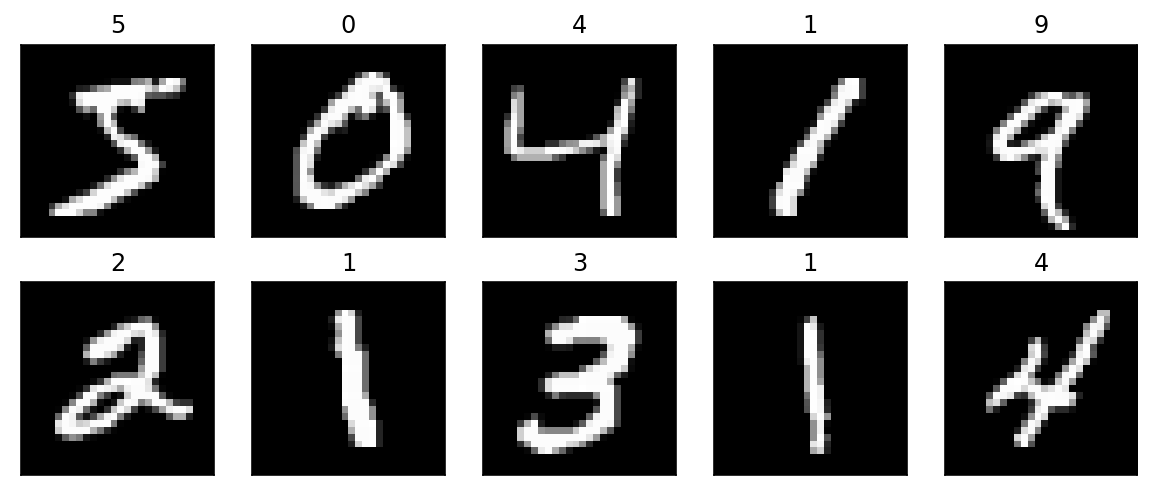

In [6]:
fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(train_imgs[idx].reshape(28, 28), cmap='gray')
    ax.set_title(str(y_train[idx]))

In artificial neural networks, the activation function of a node defines the output of that node given an input or set of inputs. we will use sigmoid activation function that looks like this 

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
 \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

In [7]:

def sigmoid(x):
    return 1 / ( 1 + np.exp(-x))


def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)

# visualize image and probability prediction
def view_classify(img, ps):
    ps = np.squeeze(ps)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(28, 28))
    ax1.set_title(ps.argmax())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [8]:
class NeuralNetwork:
    def __init__(self):
        
        self.lr = 0.001
        
        self.w1 = np.random.randn(784, 256) 
        self.b1 = np.zeros((1, 256)) 
        
        self.w2 = np.random.randn(256, 128)
        self.b2 = np.zeros((1, 128)) 
        
        self.w3 = np.random.randn(128, 10)
        self.b3 = np.zeros((1, 10))
        
        
    def feedforward(self):        
        z1 = np.dot(self.x, self.w1) + self.b1
        self.a1 = sigmoid(z1)

        z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = sigmoid(z2)

        z3 = np.dot(self.a2, self.w3) + self.b3
        self.a3 = softmax(z3)

        
        
    def backprop(self):
        
        output_errors = self.y - self.a3
        
        a3_delta = output_errors * (self.a3 * (1.0 - self.a3))  # w3
        
        z2_delta = np.dot(output_errors, self.w3.T)
        a2_delta = z2_delta * (self.a2 * (1.0 - self.a2)) # w2
        
        z1_delta = np.dot(z2_delta, self.w2.T)
        a1_delta = z1_delta * (self.a1 * (1.0 - self.a1)) # w1
        
        self.w3 += self.lr * np.dot(self.a2.T, a3_delta)
        self.b3 += self.lr * np.sum(a3_delta, axis=0, keepdims=True)
        
        self.w2 += self.lr * np.dot(self.a1.T, a2_delta)
        self.b2 += self.lr * np.sum(a2_delta, axis=0, keepdims=True)
        
        self.w1 += self.lr * np.dot(self.x.T, a1_delta)
        self.b1 += self.lr * np.sum(a1_delta, axis=0, keepdims=True)
    
    
    def train(self, x, y):
        
        '''input_vector and target_vector can 
        be tuple, list or ndarray'''
        
        self.x = np.array(x, ndmin=2)
        self.y = np.array(y, ndmin=2)
        self.feedforward()
        self.backprop()
    
    def predict(self, data):
        self.x = np.array(data, ndmin=2)
        self.feedforward()
        return self.a3
    
    
    def confusion_matrix(self, x, y):
        cm = np.zeros((10, 10), int)
        for i in range(len(x)):
            res = self.predict(x[i])
            res_max = res.argmax()
            target = y[i]
            cm[res_max, int(target)] += 1
        return cm
    
    
    def precision(self, y, confusion_matrix):
        col = confusion_matrix[:, y]
        return confusion_matrix[y, y]/col.sum()
    
    
    def recall(self, y, confusion_matrix):
        row = confusion_matrix[y, :]
        return confusion_matrix[y, y]/row.sum()
    
    
    def evaluate(self, x, y):
        corrects, wrongs = 0, 0
        for i in range(len(x)):
            res = self.predict(x[i])
            res_max = res.argmax()
            if res_max == y[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs
        

### Training
The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits.
Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. for each epoch we'll doing a training pass where we calculate the loss, do backward pass and update weighs and bias. For better accuracy you can increase the epochs.

In [9]:
model = NeuralNetwork()

epochs = 1

for epoch in range(epochs):  
    print("epoch: ", epoch+1)
    for i in range(len(train_imgs)):
        model.train(train_imgs[i], train_labels_one_hot[i])
        
    corrects, wrongs = model.evaluate(train_imgs, train_labels)
    print("accruracy train: ", corrects / ( corrects + wrongs))
    corrects, wrongs = model.evaluate(test_imgs, test_labels)
    print("accruracy test :", corrects / ( corrects + wrongs))
    print("="*50)
    cm = model.confusion_matrix(train_imgs, train_labels)
    for i in range(10):
        print("digit: ", i, "precision :", model.precision(i, cm))
        print("digit: ", i, "recall :", model.recall(i, cm))
        print("="*80)

epoch:  1
accruracy train:  0.8412666666666667
accruracy test : 0.8454
digit:  0 precision : 0.9076481512746919
digit:  0 recall : 0.921652665866621
digit:  1 precision : 0.944971818451498
digit:  1 recall : 0.9477833977982744
digit:  2 precision : 0.792212151728768
digit:  2 recall : 0.8270544944804626
digit:  3 precision : 0.8088403196868373
digit:  3 recall : 0.8342866756393001
digit:  4 precision : 0.7951044162957891
digit:  4 recall : 0.8719729678993805
digit:  5 precision : 0.8101826231322634
digit:  5 recall : 0.7323661830915458
digit:  6 precision : 0.8927002365664076
digit:  6 recall : 0.8649312377210217
digit:  7 precision : 0.8419792498004789
digit:  7 recall : 0.8809285237140948
digit:  8 precision : 0.7689283883096907
digit:  8 recall : 0.7982611781405252
digit:  9 precision : 0.8330811901159859
digit:  9 recall : 0.7355298308103295


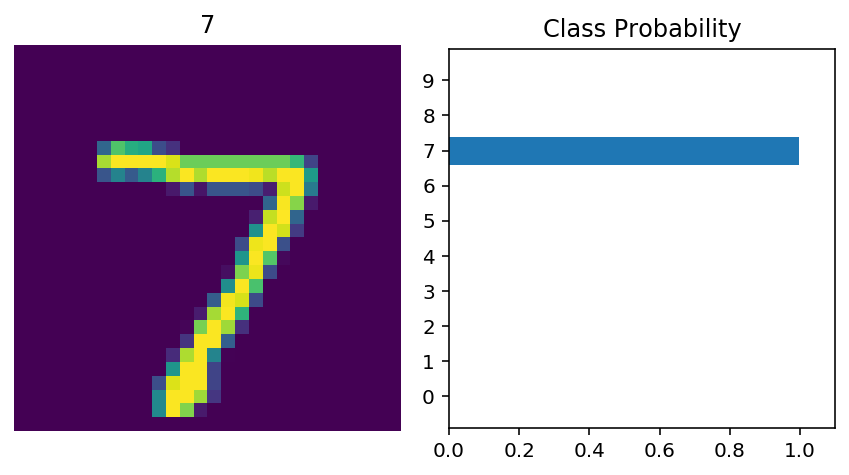

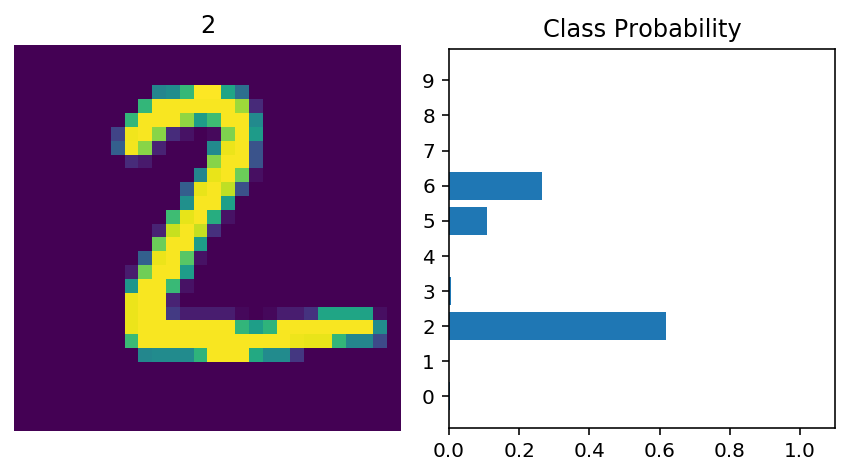

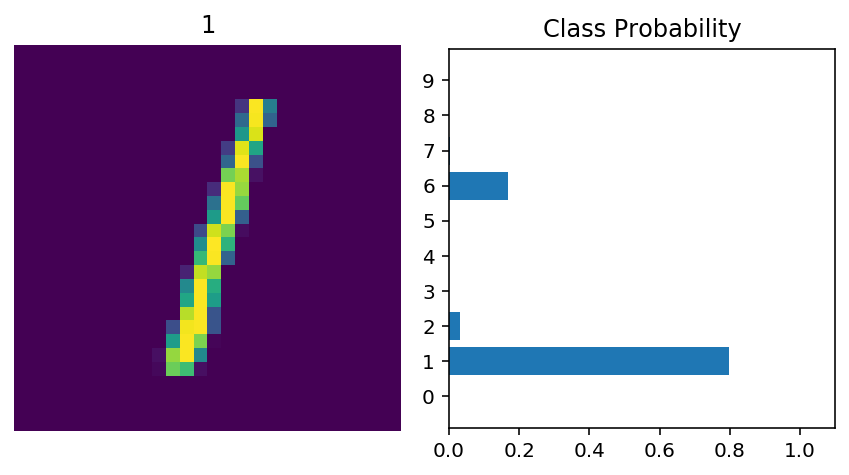

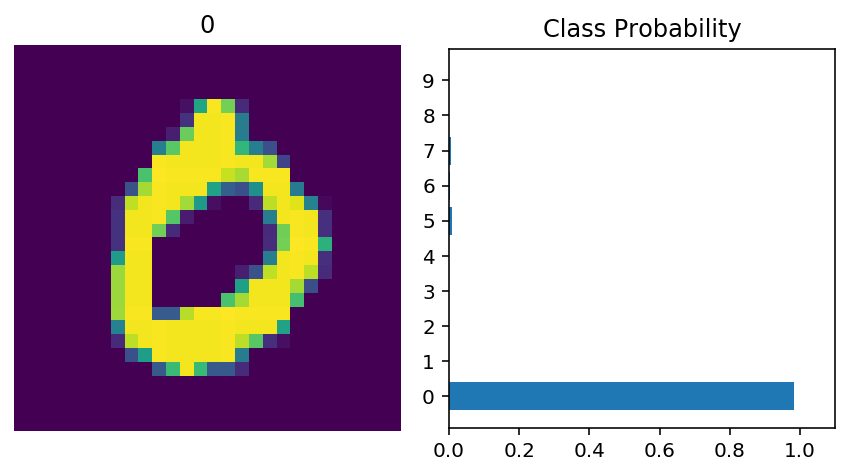

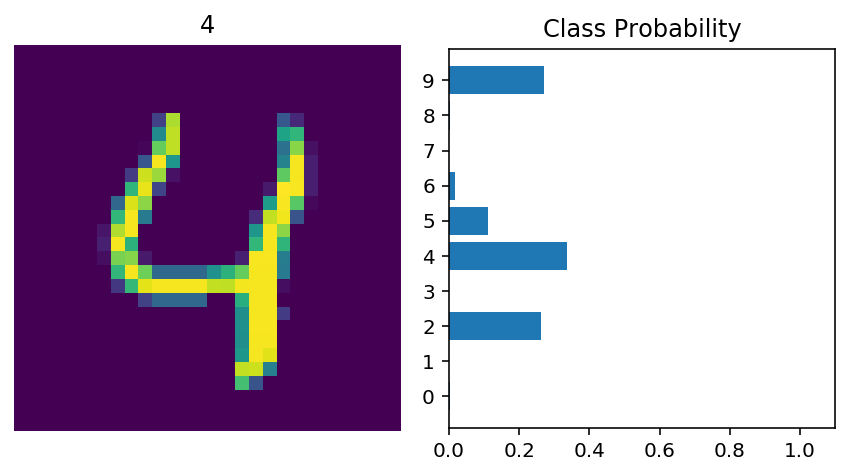

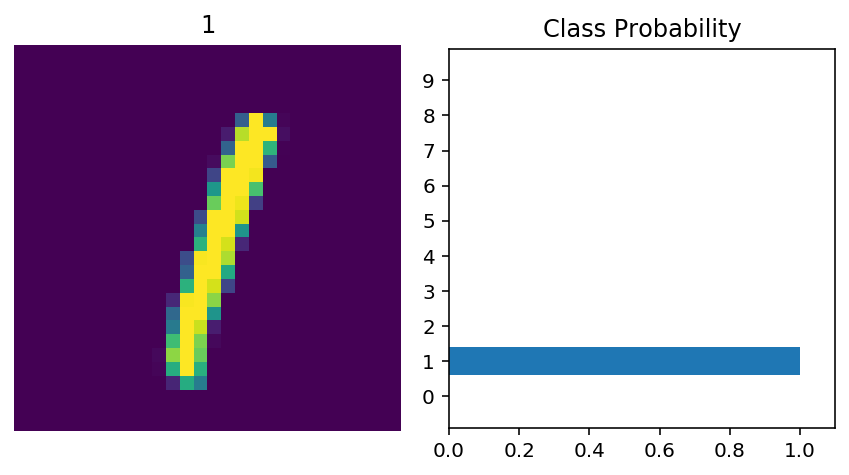

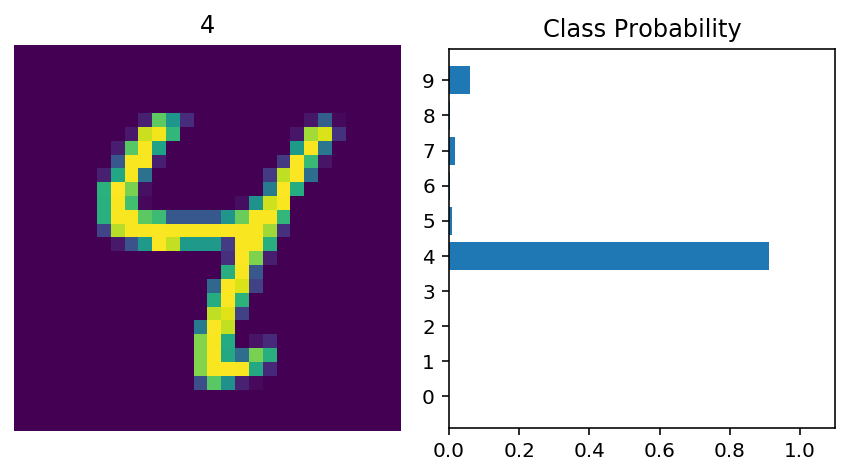

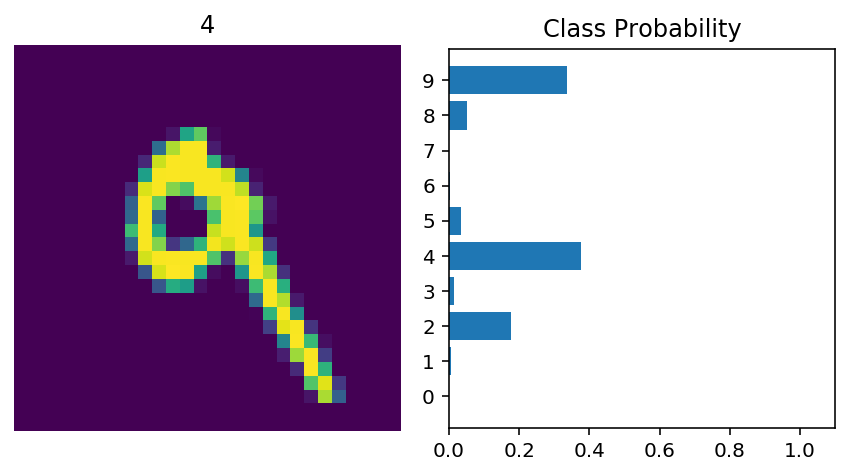

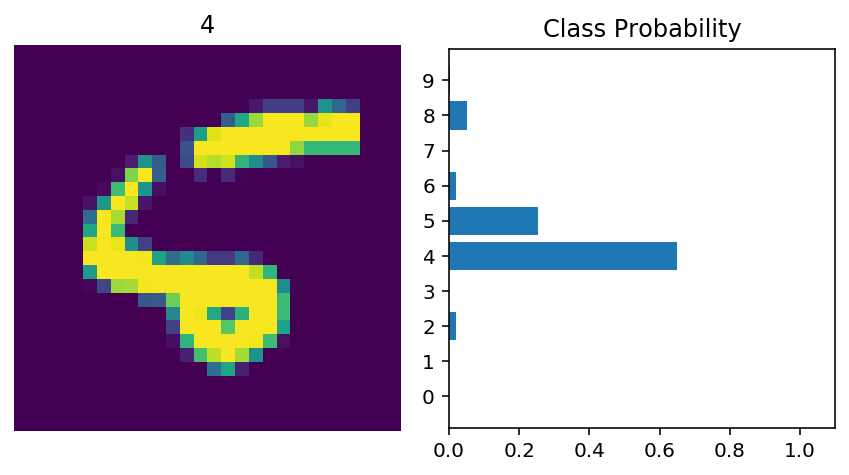

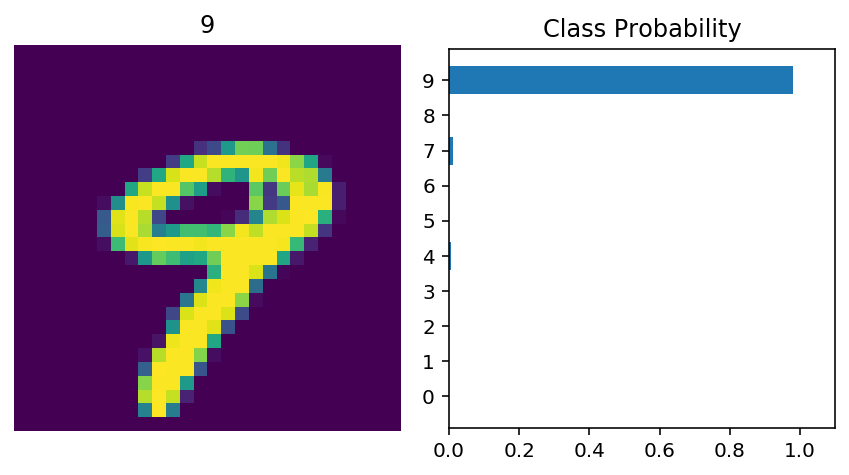

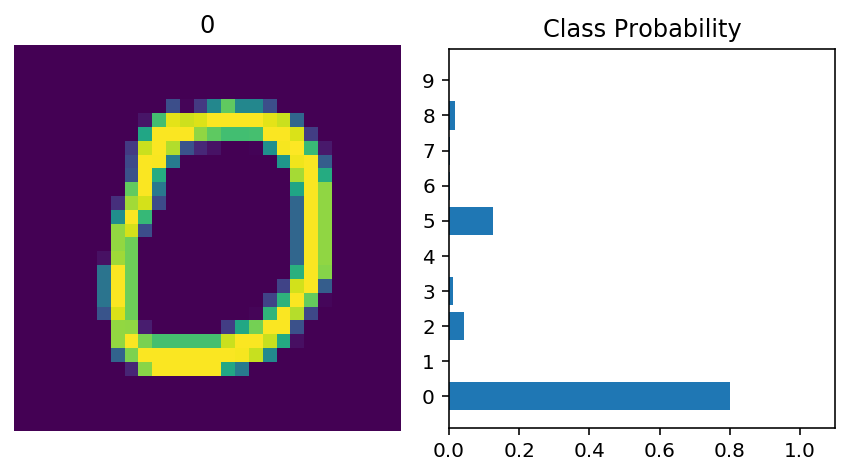

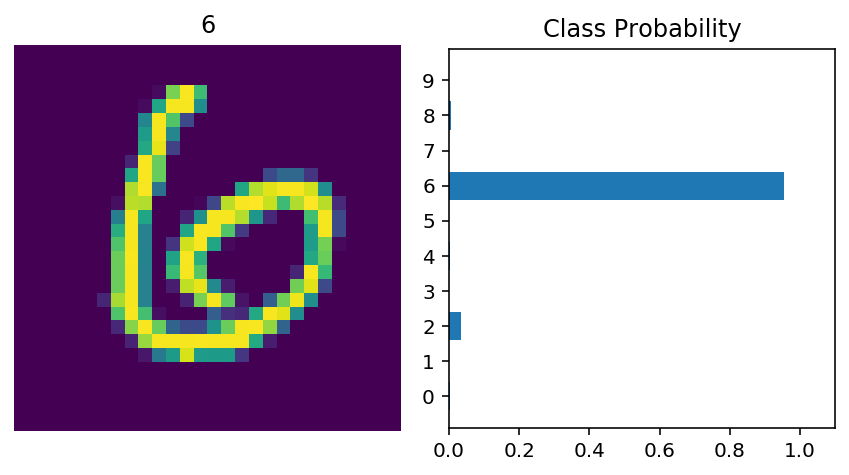

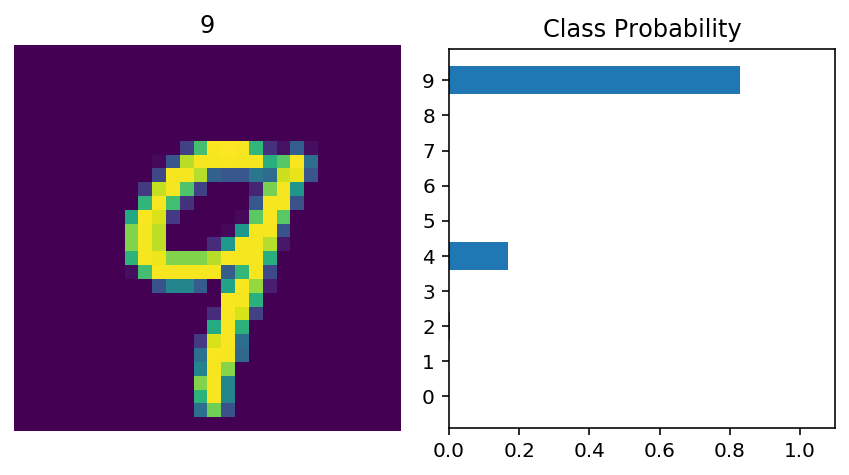

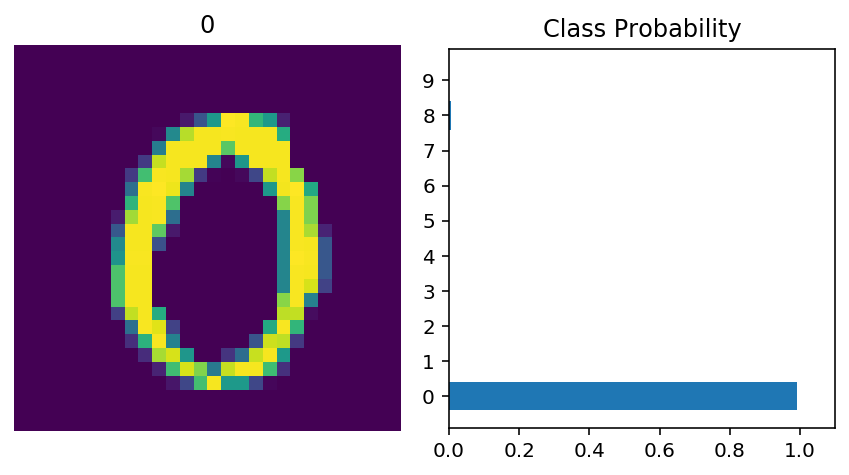

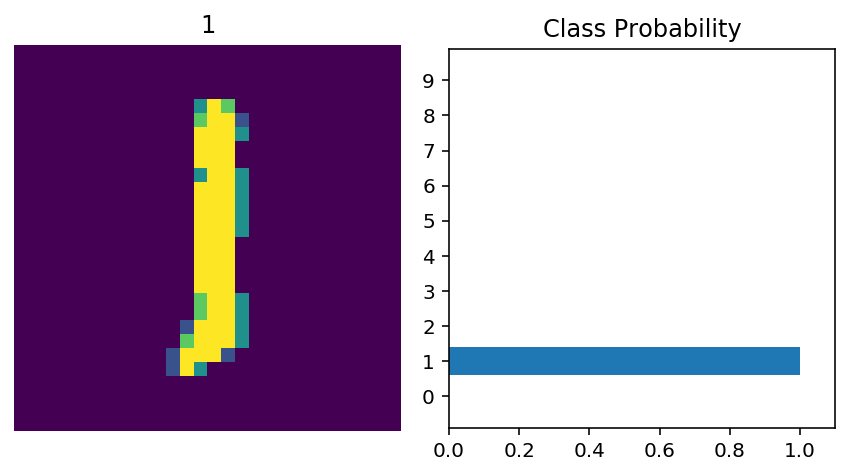

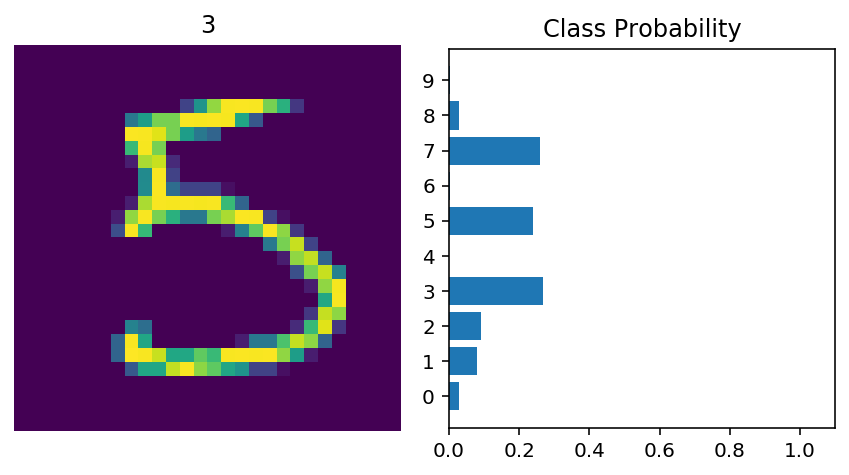

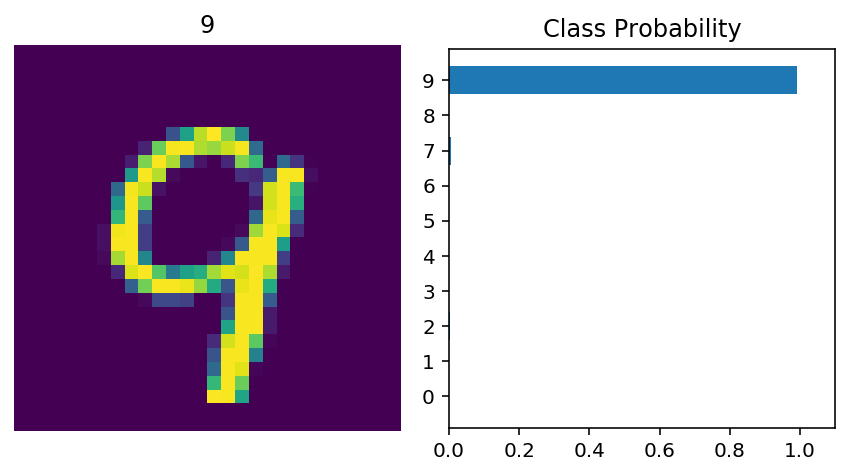

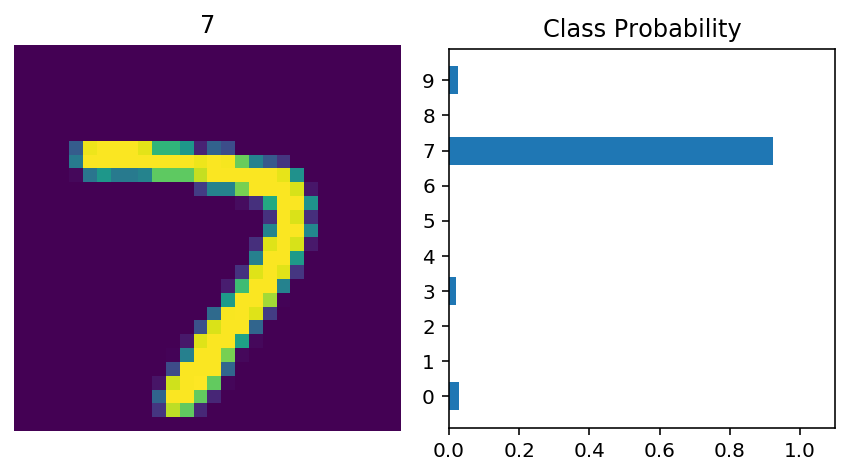

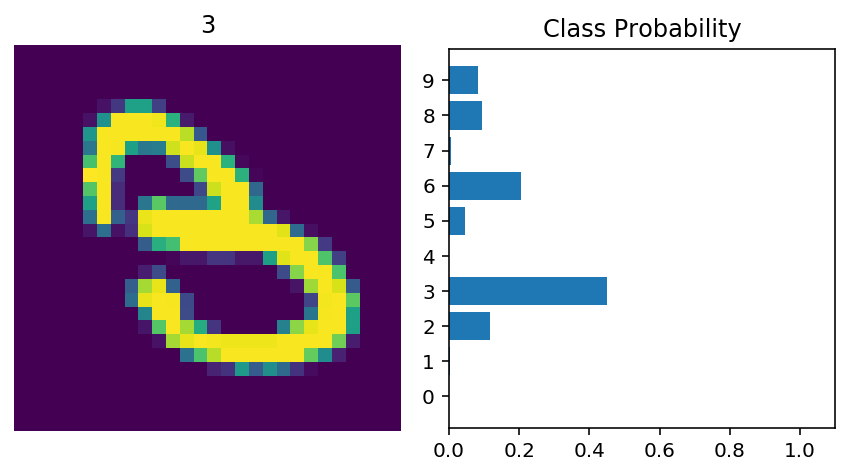

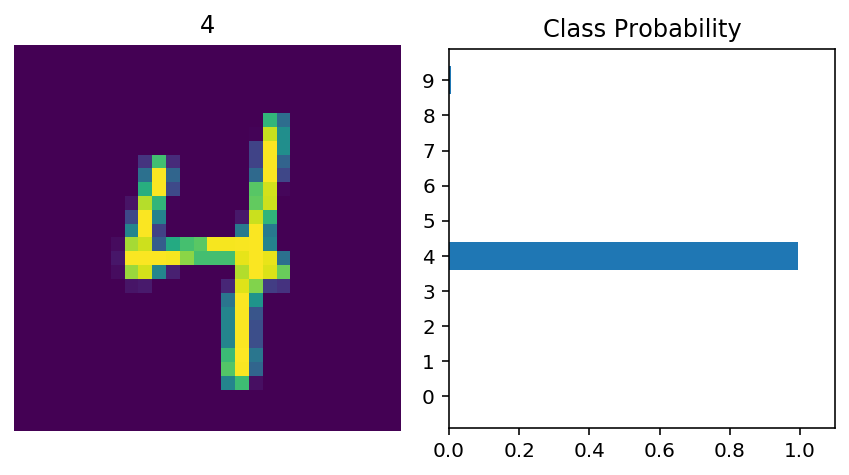

In [11]:
for i in range(20):
    prediction = model.predict(test_imgs[i])
    view_classify(test_imgs[i], prediction.reshape(1, -1))

In [13]:
import pickle
filename = "neuralnet_on_mnist.sav"
pickle.dump(model, open(filename, "wb"))

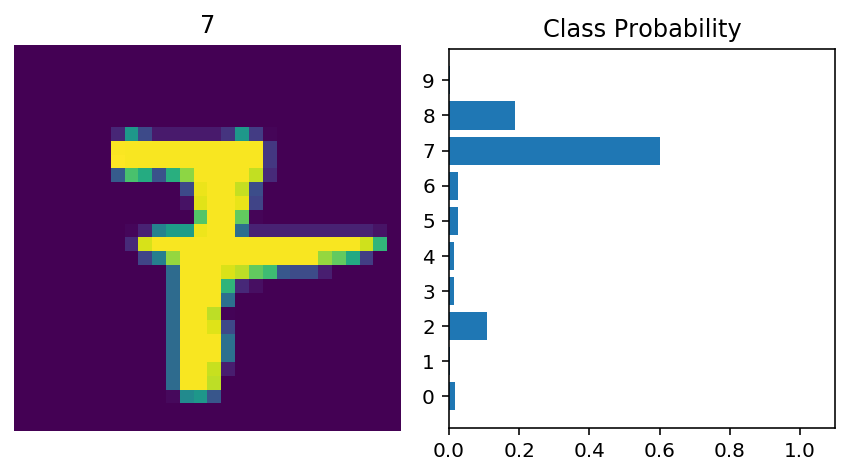

In [15]:
loaded_model = pickle.load(open(filename, "rb"))
pred = loaded_model.predict(test_imgs[97])
view_classify(test_imgs[97], pred.reshape(1, -1))